# Import Packages

In [191]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import networkx as nx
import requests
from PIL import Image
from io import BytesIO
from small_world_functions import sub_df, df_to_adjacency_matrix, monster_names_to_df, ydk_to_monster_names

# Create Adjacency Matrix of Monsters

In [192]:
card_names = ['Ash Blossom & Joyous Spring',
                'D.D. Crow',
                'Effect Veiler',
                'Ghost Belle & Haunted Mansion',
                'Mathmech Addition',
                'Mathmech Circular',
                'Mathmech Diameter',
                'Mathmech Multiplication',
                'Mathmech Nabla',
                'Mathmech Sigma',
                'Mathmech Subtraction',
                'Nibiru, the Primal Being',
                'PSY-Frame Driver',
                'PSY-Framegear Gamma']

df_deck = monster_names_to_df(card_names).reset_index(drop=True)

mathmech_matrix = df_to_adjacency_matrix(df_deck)
mathmech_matrix_squared = np.linalg.matrix_power(mathmech_matrix, 2)

# Get Images of Main Deck Monsters

In [193]:
#dataframe of all cards to get image links
def names_to_image_urls(card_names):
    with open('cardinfo.json') as file_path:
        json_all_cards = json.load(file_path)
    df_all_cards = pd.DataFrame(json_all_cards['data'])

    df_deck_images = sub_df(df_all_cards,card_names,'name')
    df_deck_images['card_images'] = df_deck_images['card_images'].apply(lambda x: x[0]['image_url_cropped'])
    urls = df_deck_images['card_images'].tolist()
    return urls

def load_image(url): 
    res = requests.get(url)
    imgage = np.array(Image.open(BytesIO(res.content)))
    return imgage

def load_images(urls):
    images = []
    for url in urls:
        image = load_image(url)
        images.append(image)
    return images

CARD_SIZE = 624
MAX_PIXEL_BRIGHTNESS = 255

def normalize_images(images):
    normalized_images = []
    for image in images:
        image_length = image.shape[0]
        image_width = image.shape[1]
        normalized_image = np.ones([CARD_SIZE,CARD_SIZE,3])*MAX_PIXEL_BRIGHTNESS
        #covering cases when image is too small
        if image_length<CARD_SIZE and image_width<CARD_SIZE: #case when length & width are too small
            normalized_image[:image_length,:image_width,:] = image
        elif image_length<CARD_SIZE: #case when only length is too small
            normalized_image[:image_length,:,:] = image[:,:CARD_SIZE,:]
        elif image_width<CARD_SIZE: #case when only width is too small
            normalized_image[:,:image_width,:] = image[:CARD_SIZE,:,:]
        else: #case when image is same size or too big
            normalized_image = image[:CARD_SIZE,:CARD_SIZE,:]
        normalized_image = normalized_image.astype(np.uint8)
        normalized_images.append(normalized_image)
    return normalized_images

def names_to_images(card_names):
    urls = names_to_image_urls(card_names)
    images = load_images(urls)
    normalized_images = normalize_images(images)
    return normalized_images

CARD_IMAGES = names_to_images(card_names)

# Generate Graph

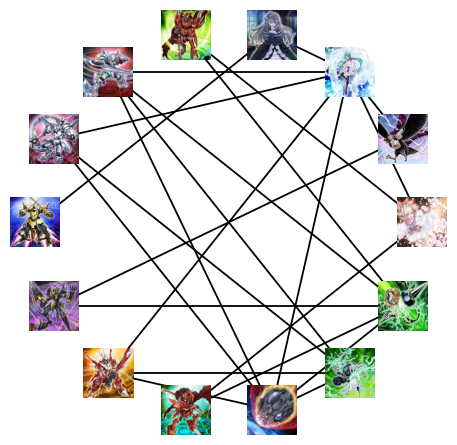

In [194]:
G = nx.from_numpy_array(mathmech_matrix)
for i in range(len(CARD_IMAGES)):
    G.nodes[i]['image'] = CARD_IMAGES[i] #asigns image to each node

pos=nx.circular_layout(G)

fig=plt.figure(figsize=(5,5))
ax=plt.subplot(111)
ax.set_aspect('equal')
nx.draw_networkx_edges(G,pos,ax=ax, width=1.3), 

plt.xlim(-1,1)
plt.ylim(-1,1)

trans=ax.transData.transform
trans2=fig.transFigure.inverted().transform

piesize=0.1 #this is the image size
p2=piesize/2.0
for n in G:
    xx,yy=trans(pos[n]) #figure coordinates
    xa,ya=trans2((xx,yy)) #axes coordinates
    a = plt.axes([xa-p2,ya-p2, piesize, piesize])
    a.set_aspect('equal')
    a.imshow(G.nodes[n]['image'])
    a.axis('off')
ax.axis('off')
plt.savefig('images\mathmech-graph.png')
plt.show()

# Generate Matrix Images

In [195]:
#Assumptions: all images are the same size and square
def generate_matrix_image(matrix, highlighted_columns=[]):
    num_cards = len(CARD_IMAGES)

    vertical_cards = np.concatenate(CARD_IMAGES, axis=1) #concatenated images horizontally
    horizontal_cards = np.concatenate(CARD_IMAGES, axis=0) #concatenated images vertically
    image_size = CARD_SIZE*(num_cards+1)
    matrix_subimage_size = CARD_SIZE*num_cards

    full_image = np.ones((image_size,image_size,3))*MAX_PIXEL_BRIGHTNESS

    #card images
    full_image[CARD_SIZE:,0:CARD_SIZE,:] = horizontal_cards
    full_image[0:CARD_SIZE,CARD_SIZE:,:] = vertical_cards

    matrix_subimage = (np.ones((matrix_subimage_size,matrix_subimage_size,3))*MAX_PIXEL_BRIGHTNESS)

    matrix_maximum = np.max(matrix)
    if highlighted_columns != []:
        highlighted_maximum = np.max(matrix[:,highlighted_columns])

    #color in cells
    for i in range(num_cards):
        for j in range(num_cards):
            matrix_entry = matrix[i,j]
            if matrix_entry>0:
                if j in highlighted_columns:
                    #highlighted cell color
                    red_highlight_max = 255
                    green_highlight_max = 220
                    blue_highlight_max = 220
                    matrix_subimage[i*CARD_SIZE:(i+1)*CARD_SIZE,j*CARD_SIZE:(j+1)*CARD_SIZE,0] = red_highlight_max
                    matrix_subimage[i*CARD_SIZE:(i+1)*CARD_SIZE,j*CARD_SIZE:(j+1)*CARD_SIZE,1] = green_highlight_max*(1-matrix_entry/highlighted_maximum)
                    matrix_subimage[i*CARD_SIZE:(i+1)*CARD_SIZE,j*CARD_SIZE:(j+1)*CARD_SIZE,2] = blue_highlight_max*(1-matrix_entry/highlighted_maximum)
                else:
                    #greyscale cell color
                    cell_brightness_max = 220
                    matrix_subimage[i*CARD_SIZE:(i+1)*CARD_SIZE,j*CARD_SIZE:(j+1)*CARD_SIZE,:] = cell_brightness_max*(1-matrix_entry/matrix_maximum)
    full_image[CARD_SIZE:,CARD_SIZE:,:] = matrix_subimage

    full_image = full_image.astype(np.uint8)
    return full_image

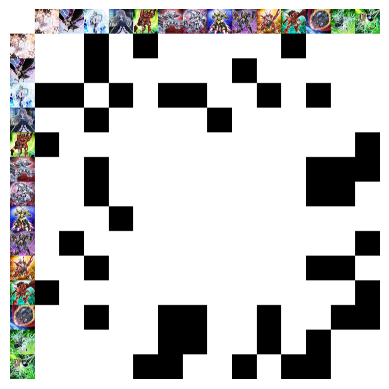

In [196]:
mathmech_matrix_image = generate_matrix_image(mathmech_matrix)

fig = plt.imshow(mathmech_matrix_image)
ax = plt.subplot(111)
ax.axis('off')
plt.savefig('images\mathmech-adjacency-matrix.png', dpi=128.5, bbox_inches='tight')
plt.show()

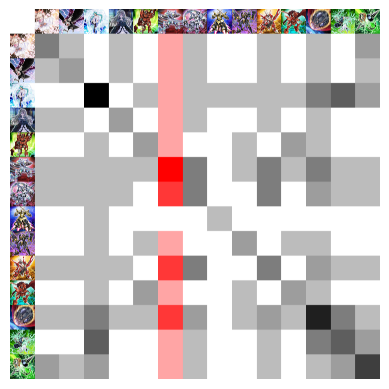

In [197]:
mathmech_circ_index = df_deck[df_deck['name']=='Mathmech Circular'].index[0]
mathmech_matrix_squared_image = generate_matrix_image(mathmech_matrix_squared, highlighted_columns=[mathmech_circ_index])

fig = plt.imshow(mathmech_matrix_squared_image)
ax = plt.subplot(111)
ax.axis('off')
plt.savefig('images\mathmech-adjacency-matrix-squared.png', dpi=128.5, bbox_inches='tight')
plt.show()